In [10]:
import pandas as pd
import numpy as np
import random
import pickle

from sklearn.inspection import permutation_importance
from data_preparation_tools import preprocessing_data

from cv_wrappers_and_tools import cv_random_forest, save_model_and_results, make_prediction_rf, plot_roc_auc

# RandomForest

## Grid search

In [3]:
df_train = pd.read_csv('input/cybersecurity_training.csv', sep='|', index_col=0)
df_test = pd.read_csv('input/cybersecurity_test.csv', sep='|', index_col=0)
print(df_train.shape)
print(df_test.shape)
df_train.head()

(39427, 62)
(20000, 61)


,client_code,notified,categoryname,ip,ipcategory_name,ipcategory_scope,parent_category,grandparent_category,overallseverity,timestamp_dist,...,thrcnt_week,thrcnt_day,p6,p9,p5m,p5w,p5d,p8m,p8w,p8d
alert_ids,,,,,,,,,,,,,,,,,,,,,
Nhq,DPM,0,Attack,YT.LB.32.21,INTERNET,Internet,7,A,3,65684,...,4160,675,1,0,2,1,1,1,1,1
XZt,FIN,0,Exploit,192.SL.UK.94,PRIV-192,Private network,1,A,5,1188030,...,9,2,4,12,3,2,2,2,1,1
bBz,CHP,0,Attack,YT.LB.38.21,INTERNET,Internet,7,A,4,43716,...,3788,628,1,0,2,2,1,2,2,1
ZNr,HPS,0,Attack,JX.NY.13.20,INTERNET,Internet,7,A,4,0,...,565,96,0,0,2,2,2,2,2,2
poV,OSC,0,Attack,YT.LB.32.21,INTERNET,Internet,7,A,4,2401,...,2790,632,1,0,1,1,1,1,1,1


In [4]:
# Select features, that won't be used to create predictive models
feature_black_list = ['grandparent_category', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'score']
# Select target variable
target = 'notified'
# Prepare  training and test datasets for modeling
preproc_train_df, preproc_test_df, _, features = preprocessing_data(df_train, df_test, target, feature_black_list)

In [6]:
# The first training model with default parameters
trainResults, testResults, *_ = cv_random_forest(preproc_train_df, target, features, debug=True)
print(f'Train mean: {np.mean(trainResults)}, Test mean: {np.mean(testResults)}, Diff: {np.mean(trainResults) - np.mean(testResults)}')

RandomForestClassifier(n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9132549861657653
RandomForestClassifier(n_jobs=-1, random_state=2022)
Train AUC: 0.9999999999999999 Valid AUC: 0.9262676796297609
RandomForestClassifier(n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9259456021770962
RandomForestClassifier(n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9210901749663526
RandomForestClassifier(n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9203842456332363
Train mean: 1.0, Test mean: 0.9213885377144422, Diff: 0.07861146228555782


In [7]:
# Trying to find the best hyperparameters using Grid Search
for n_estimators in range(100, 601, 100):
    trainResults, testResults, *_ = cv_random_forest(train_df=preproc_train_df, features=features, target=target, n_estimators=n_estimators)
    print(f'n_estimators: {n_estimators}, Train mean: {np.mean(trainResults)}, Test mean: {np.mean(testResults)}, Diff: {np.mean(trainResults) - np.mean(testResults)}')

n_estimators: 100, Train mean: 1.0, Test mean: 0.9213885377144422, Diff: 0.07861146228555782
n_estimators: 200, Train mean: 1.0, Test mean: 0.9250760807950451, Diff: 0.07492391920495489
n_estimators: 300, Train mean: 1.0, Test mean: 0.9261972784126007, Diff: 0.07380272158739931
n_estimators: 400, Train mean: 1.0, Test mean: 0.92655364130206, Diff: 0.07344635869794003
n_estimators: 500, Train mean: 1.0, Test mean: 0.9269326274049451, Diff: 0.07306737259505491
n_estimators: 600, Train mean: 1.0, Test mean: 0.9270540295356657, Diff: 0.07294597046433426


In [13]:
for n_estimators in range(600, 1101, 100):
    trainResults, testResults, *_ = cv_random_forest(train_df=preproc_train_df, features=features, target=target, n_estimators=n_estimators)
    print(f'n_estimators: {n_estimators}, Train mean: {np.mean(trainResults):.3f}, Test mean: {np.mean(testResults):.3f}, Diff: {(np.mean(trainResults) - np.mean(testResults)):.3f}')

n_estimators: 600, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
n_estimators: 700, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
n_estimators: 800, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
n_estimators: 900, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
n_estimators: 1000, Train mean: 1.000, Test mean: 0.928, Diff: 0.072


KeyboardInterrupt: 

In [14]:
for max_depth in range(14,28,2):
    trainResults, testResults, *_ = cv_random_forest(train_df=preproc_train_df, features=features, target=target, n_estimators=800, max_depth=max_depth)
    print(f'max_depth: {max_depth}, Train mean: {np.mean(trainResults):.3f}, Test mean: {np.mean(testResults):.3f}, Diff: {(np.mean(trainResults) - np.mean(testResults)):.3f}')

max_depth: 14, Train mean: 0.997, Test mean: 0.919, Diff: 0.079
max_depth: 16, Train mean: 1.000, Test mean: 0.923, Diff: 0.077
max_depth: 18, Train mean: 1.000, Test mean: 0.925, Diff: 0.075
max_depth: 20, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
max_depth: 22, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_depth: 24, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
max_depth: 26, Train mean: 1.000, Test mean: 0.928, Diff: 0.072


In [6]:
for max_features in range(7, 16, 1):
    trainResults, testResults, *_ = cv_random_forest(train_df=preproc_train_df, features=features, target=target, n_estimators=800, max_depth=26, max_features=max_features)
    print(f'max_features: {max_features}, Train mean: {np.mean(trainResults):.3f}, Test mean: {np.mean(testResults):.3f}, Diff: {(np.mean(trainResults) - np.mean(testResults)):.3f}')

max_features: 7, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_features: 8, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_features: 9, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
max_features: 10, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_features: 11, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_features: 12, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_features: 13, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
max_features: 14, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
max_features: 15, Train mean: 1.000, Test mean: 0.928, Diff: 0.072


In [7]:
for min_samples_split in [2, 3, 4, 5, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, *_ = cv_random_forest(train_df=preproc_train_df, features=features, target=target, n_estimators=800, max_depth=26, max_features=11, min_samples_split=min_samples_split)
    print(f'min_samples_split: {min_samples_split}, Train mean: {np.mean(trainResults):.3f}, Test mean: {np.mean(testResults):.3f}, Diff: {(np.mean(trainResults) - np.mean(testResults)):.3f}')

min_samples_split: 2, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
min_samples_split: 3, Train mean: 1.000, Test mean: 0.928, Diff: 0.072
min_samples_split: 4, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
min_samples_split: 5, Train mean: 1.000, Test mean: 0.926, Diff: 0.074
min_samples_split: 6, Train mean: 1.000, Test mean: 0.927, Diff: 0.073
min_samples_split: 8, Train mean: 1.000, Test mean: 0.925, Diff: 0.075
min_samples_split: 10, Train mean: 1.000, Test mean: 0.925, Diff: 0.075
min_samples_split: 15, Train mean: 0.999, Test mean: 0.923, Diff: 0.076
min_samples_split: 20, Train mean: 0.997, Test mean: 0.921, Diff: 0.076
min_samples_split: 30, Train mean: 0.993, Test mean: 0.918, Diff: 0.075


In [46]:
# Final model with hyperparameters that were found by Grid Search
trainResults, testResults, predictions, indexes, models = cv_random_forest(preproc_train_df, target, features, debug=True, mlflow_tracking=True, exp_name='Experiment_1_RF', n_estimators=800, max_depth=26, max_features=11, min_samples_split=3, min_samples_leaf = 1)
print(f'Train mean: {np.mean(trainResults):.3f}, Test mean: {np.mean(testResults):.3f}, Diff: {(np.mean(trainResults) - np.mean(testResults)):.3f}')

RandomForestClassifier(max_depth=26, max_features=11, min_samples_split=3,
                       n_estimators=800, n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9214425461498534
RandomForestClassifier(max_depth=26, max_features=11, min_samples_split=3,
                       n_estimators=800, n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9316546539633066
RandomForestClassifier(max_depth=26, max_features=11, min_samples_split=3,
                       n_estimators=800, n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.932556313135048
RandomForestClassifier(max_depth=26, max_features=11, min_samples_split=3,
                       n_estimators=800, n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9272665020040526
RandomForestClassifier(max_depth=26, max_features=11, min_samples_split=3,
                       n_estimators=800, n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9261591705737062
Train mean: 1.000, Test mean: 0.928, Diff: 0.0

In [47]:
# Save results to file
modelRF= {
    "name":"RF-2_GS",
    "description":"Model Random Forest",
    "specification":'n_estimators=800, max_depth=26, max_features=11, min_samples_split=3, min_samples_leaf = 1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indexes.copy(),
    "features": features.copy()
}
save_model_and_results('model_RF_2', modelRF)

## Features importance

In [10]:
# Checking which parameters have the highest and lowest predictive power
imps = list(zip(models[0].feature_importances_, features))
imps.sort(reverse=True)
imps

[(0.09327166308777758, 'ip'),
 (0.0765717808423343, 'thrcnt_month'),
 (0.07501511280383924, 'client_code'),
 (0.07246224195185441, 'thrcnt_week'),
 (0.06172739527002609, 'timestamp_dist'),
 (0.0539159947130435, 'start_minute'),
 (0.05319980162480642, 'start_second'),
 (0.05025783537438015, 'start_hour'),
 (0.05001424381825098, 'thrcnt_day'),
 (0.04994486367179078, 'correlatedcount'),
 (0.03732707673133568, 'categoryname'),
 (0.032267380209864506, 'weekday'),
 (0.021695975401261624, 'untrustscore'),
 (0.020412143732095024, 'flowscore'),
 (0.015694700189062098, 'srcipcategory_dominate'),
 (0.015290099524540985, 'srcport_cd'),
 (0.014671430210779955, 'overallseverity'),
 (0.012586640294484596, 'p8m'),
 (0.011915333283625472, 'dstip_cd'),
 (0.01188817652985421, 'p5m'),
 (0.0112185220834468, 'ipcategory_name'),
 (0.009810415157257599, 'p8w'),
 (0.009751031920101834, 'srcportcategory_dominate'),
 (0.009577650064221213, 'enforcementscore'),
 (0.009561418945441115, 'p5w'),
 (0.0084480222431476

In [ ]:
r = permutation_importance(models[0], preproc_train_df[features], preproc_train_df[target], n_repeats=10,random_state=0, scoring='roc_auc')
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

## Random Search

In [ ]:
# Trying to find the best hyperparameters using Random Search
results = []
for k in range(1000):

    params = {
        "max_depth": random.randint(6, 28),
        "max_features": random.randint(2, 12),
        "min_samples_split": random.randint(2, 9),
        "n_estimators": random.choice(range(100, 1001, 25))
    }
    # The value of min_samples_leaf must be less than min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])

    # Model estimation for drawn hyperparameters
    trainResults, testResults, predictions, indexes, _ = cv_random_forest(preproc_train_df, target, features,
                                                                          debug=False, mlflow_tracking=True,
                                                                          exp_name='Experiment_2_RF_Random_Search',
                                                                          n_estimators=params["n_estimators"],
                                                                          max_depth=params["max_depth"],
                                                                          max_features=params["max_features"],
                                                                          min_samples_split=params["min_samples_split"],
                                                                          min_samples_leaf=params["min_samples_leaf"])

    # Saving results
    results.append((np.mean(testResults), params.copy()))

    # Display results of current iteration
    print(params, np.mean(testResults))

    # Every 10 iterations display top 3 results from all iterations
    if k>1 and k%10==0:
        print("\n Top 3:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:3]:
            print(params, score)
        print()

{'max_depth': 21, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 875, 'min_samples_leaf': 1} 0.922610582420945
{'max_depth': 17, 'max_features': 6, 'min_samples_split': 7, 'n_estimators': 275, 'min_samples_leaf': 1} 0.92034520867946
{'max_depth': 24, 'max_features': 7, 'min_samples_split': 4, 'n_estimators': 850, 'min_samples_leaf': 3} 0.923934444542571
{'max_depth': 25, 'max_features': 3, 'min_samples_split': 7, 'n_estimators': 100, 'min_samples_leaf': 5} 0.9087506522871422
{'max_depth': 18, 'max_features': 12, 'min_samples_split': 2, 'n_estimators': 700, 'min_samples_leaf': 2} 0.9256446771673611
{'max_depth': 28, 'max_features': 8, 'min_samples_split': 6, 'n_estimators': 425, 'min_samples_leaf': 3} 0.9242014097122817
{'max_depth': 14, 'max_features': 7, 'min_samples_split': 7, 'n_estimators': 950, 'min_samples_leaf': 3} 0.917934294317275
{'max_depth': 24, 'max_features': 11, 'min_samples_split': 8, 'n_estimators': 800, 'min_samples_leaf': 3} 0.9249018999667064
{'max_depth

In [5]:
# Final model with hyperparameters that were found by Random Search
trainResults, testResults, predictions, indexes, models = cv_random_forest(preproc_train_df, target, features, debug=True, mlflow_tracking=True, exp_name='Experiment_2_RF_Random_Search', n_estimators=925, max_depth=27, max_features=10, min_samples_split=2, min_samples_leaf = 1)
print(f'Train mean: {np.mean(trainResults):.2f}, Test mean: {np.mean(testResults):.4f}, Diff: {(np.mean(trainResults) - np.mean(testResults)):.3f}')

RandomForestClassifier(max_depth=27, max_features=10, n_estimators=925,
                       n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9213993650004955
RandomForestClassifier(max_depth=27, max_features=10, n_estimators=925,
                       n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9316274999409696
RandomForestClassifier(max_depth=27, max_features=10, n_estimators=925,
                       n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.933137266502004
RandomForestClassifier(max_depth=27, max_features=10, n_estimators=925,
                       n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.9273296555396152
RandomForestClassifier(max_depth=27, max_features=10, n_estimators=925,
                       n_jobs=-1, random_state=2022)
Train AUC: 1.0 Valid AUC: 0.926640586869389
Train mean: 1.00, Test mean: 0.9280, Diff: 0.072


In [45]:
modelRF= {
    "name":"RF-3_RS",
    "description":"Model Random Forest",
    "specification":'n_estimators=925, max_depth=27, max_features=10, min_samples_split=2',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indexes.copy(),
    "features": features.copy()
}
save_model_and_results('model_RF_3', modelRF)

## Making prediction for competition

In [13]:
# Now we can choose the best model in mlflow and make final prediction to get results of target variable
params = {
    'n_estimators': 925,
    'max_depth': 27,
    'max_features': 10,
    'min_samples_split':2,
    'min_samples_leaf':1,
}
preds = make_prediction_rf(preproc_train_df, preproc_test_df, features, target, 'results_3_rf', 2022, True, **params)

## Comparing the results of different predictive models

In [6]:
with open("output/models/model_RF_1.p", "rb") as fp:
    model_RF_1 = pickle.load(fp)

with open("output/models/model_RF_2.p", "rb") as fp:
    model_RF_2 = pickle.load(fp)

with open("output/models/model_RF_3.p", "rb") as fp:
    model_RF_3 = pickle.load(fp)

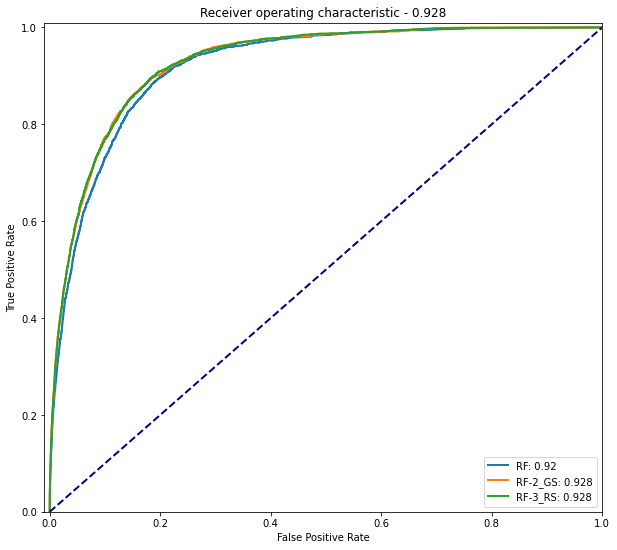

AAB    0.003421
AAC    0.000000
AAE    0.214708
AAL    0.000000
AAP    0.056364
         ...   
zze    0.419730
zzl    0.036951
zzr    0.098378
zzs    0.000000
zzz    0.000000
Length: 39427, dtype: float64

In [9]:
# Prepare data for the AUC-ROC curve
res2plot = []
true = preproc_train_df[target].sort_index()
for result in [model_RF_1, model_RF_2, model_RF_3]:
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

# Plot AUC-ROC curves
plot_roc_auc(res2plot)